In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import os

In [55]:
from pathlib import Path

# Configurable parts
SYMBOL = "USDJPY"
SAMPLE_TYPE = "time"
MINUTES = 1

START_DATE = "20240101"
END_DATE = "20241231"

# Build base name
RESAMPLED_NAME = f"{SYMBOL}-{MINUTES}m-{START_DATE}-{END_DATE}"

# Base directories
BASE_DIR = Path("../data")
RESAMPLED_DIR = BASE_DIR / "resampled"
PROCESSED_DIR = BASE_DIR / "processed"
EVENTS_DIR = BASE_DIR / "events"

# Final paths
RESAMPLED_FILE_PATH = RESAMPLED_DIR / f"{RESAMPLED_NAME}.pkl"
PROCESSED_FILE_PATH = PROCESSED_DIR / f"{RESAMPLED_NAME}-processed.pkl"

## Load Data

In [56]:
df = pd.read_pickle(PROCESSED_FILE_PATH)

In [57]:
df.shape

(371236, 100)

## Find Elliott Wave Impulse Wave

In [58]:
def is_impulse(waves: pd.Series):
    prices = waves.values
    indices = waves.index

    if waves.shape[0] < 6:
        return False
        
    if not (prices[0] < prices[1] > prices[2] < prices[3] > prices[4] < prices[5]):
        return False

    if not prices[5] > prices[3]:
        return False

    if not prices[3] > prices[1]:
        return False

    if not prices[4] > prices[2]:
        return False

    return True

def find_ew(prices: pd.Series):
    indices = []
    for i in range(0, prices.shape[0] - 5):
        if is_impulse(prices[i:i+6]):
            indices.append(prices.index[i])
    return pd.DatetimeIndex(indices)

In [59]:
close_waves_idx = find_ew(df['close'])
close_waves_idx

DatetimeIndex(['2024-01-02 01:59:00', '2024-01-02 05:30:00',
               '2024-01-02 05:41:00', '2024-01-02 09:08:00',
               '2024-01-02 14:17:00', '2024-01-03 00:13:00',
               '2024-01-03 01:58:00', '2024-01-03 02:47:00',
               '2024-01-03 03:22:00', '2024-01-03 04:08:00',
               ...
               '2024-12-30 01:29:00', '2024-12-30 02:33:00',
               '2024-12-30 02:35:00', '2024-12-30 03:33:00',
               '2024-12-30 08:31:00', '2024-12-30 10:35:00',
               '2024-12-30 11:30:00', '2024-12-30 11:32:00',
               '2024-12-30 11:59:00', '2024-12-30 22:06:00'],
              dtype='datetime64[ns]', length=1687, freq=None)

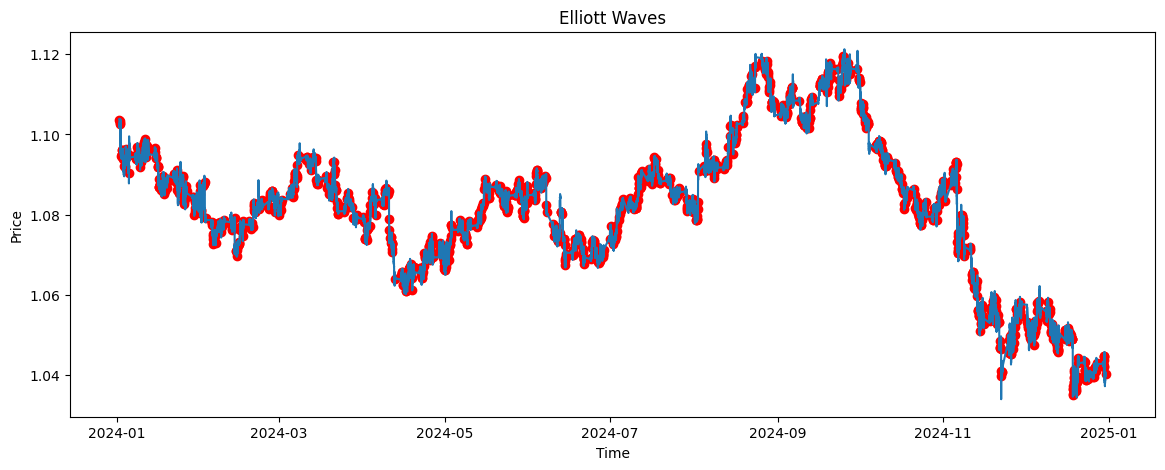

In [62]:
# Using the outputs from (2)
plt.figure(figsize=(14,5))
plt.plot(df.index, df['close'])
plt.scatter(close_waves_idx, df['close'].loc[close_waves_idx], c='r')

plt.title('Elliott Waves')
plt.xlabel('Time'); plt.ylabel('Price')
plt.show()

## Combine ZigZag extrema with Elliott Wave

In [63]:
import pandas_ta as ta

In [70]:
LEGS = 5
THRESHOLD = .01

In [71]:
zigzag = df.ta.zigzag(legs=LEGS, deviation=THRESHOLD)

In [72]:
t_events = zigzag[zigzag[f"ZIGZAGs_{THRESHOLD}%_{LEGS}"]==True].index
t_events

DatetimeIndex(['2024-01-02 01:54:00', '2024-01-02 02:00:00',
               '2024-01-02 02:03:00', '2024-01-02 02:11:00',
               '2024-01-02 02:36:00', '2024-01-02 02:45:00',
               '2024-01-02 02:56:00', '2024-01-02 03:00:00',
               '2024-01-02 03:18:00', '2024-01-02 03:33:00',
               ...
               '2024-12-30 20:41:00', '2024-12-30 20:46:00',
               '2024-12-30 20:55:00', '2024-12-30 21:03:00',
               '2024-12-30 21:27:00', '2024-12-30 22:00:00',
               '2024-12-30 22:12:00', '2024-12-30 22:36:00',
               '2024-12-30 23:00:00', '2024-12-30 23:56:00'],
              dtype='datetime64[ns]', name='timestamp', length=32418, freq=None)

In [73]:
zz = df['close'].loc[t_events]
zz

timestamp
2024-01-02 01:54:00    1.103805
2024-01-02 02:00:00    1.103540
2024-01-02 02:03:00    1.103500
2024-01-02 02:11:00    1.103245
2024-01-02 02:36:00    1.102640
                         ...   
2024-12-30 22:00:00    1.040530
2024-12-30 22:12:00    1.040340
2024-12-30 22:36:00    1.040430
2024-12-30 23:00:00    1.040195
2024-12-30 23:56:00    1.040580
Name: close, Length: 32418, dtype: float64

In [74]:
zz_waves_idx = find_ew(zz)
zz_waves_idx

DatetimeIndex(['2024-01-08 15:18:00', '2024-01-09 01:54:00',
               '2024-01-09 16:59:00', '2024-01-10 04:06:00',
               '2024-01-10 09:33:00', '2024-01-12 02:29:00',
               '2024-01-15 16:38:00', '2024-01-16 05:49:00',
               '2024-01-17 21:18:00', '2024-01-19 01:53:00',
               ...
               '2024-12-11 15:42:00', '2024-12-11 16:02:00',
               '2024-12-15 23:02:00', '2024-12-16 12:44:00',
               '2024-12-20 18:45:00', '2024-12-23 01:35:00',
               '2024-12-24 01:27:00', '2024-12-26 09:32:00',
               '2024-12-27 13:32:00', '2024-12-30 11:14:00'],
              dtype='datetime64[ns]', length=228, freq=None)

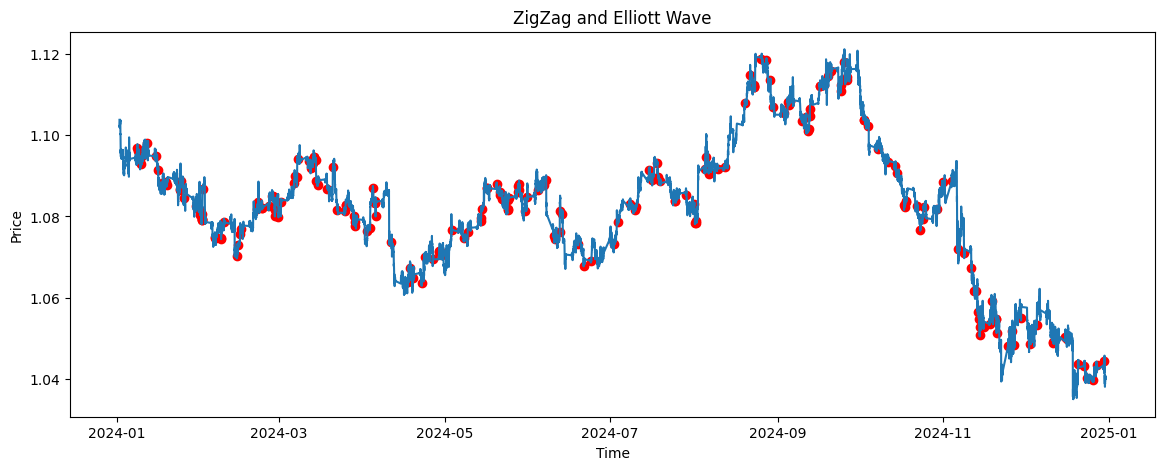

In [75]:
# Using the outputs from (2)
plt.figure(figsize=(14,5))
plt.plot(zz.index, zz)
plt.scatter(zz_waves_idx, zz.loc[zz_waves_idx], c='r')  # connective segments
plt.title('ZigZag and Elliott Wave')
plt.xlabel('Time'); plt.ylabel('Price')
plt.show()